<a href="https://colab.research.google.com/github/ekene966/FreeML/blob/master/DE_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import librairies
# import wget
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15,15]

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=52c805107087468a809f7ee732bef30e58dcac400737de80e43cefbd62dd0f43
  Stored in directory: c:\users\ekene\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [3]:
!wget csit.udc.edu/~jkim/data/netflix_titles.csv

--2021-02-25 21:52:25--  http://csit.udc.edu/~jkim/data/netflix_titles.csv
Resolving csit.udc.edu (csit.udc.edu)... 38.105.74.10
Connecting to csit.udc.edu (csit.udc.edu)|38.105.74.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3000491 (2.9M) [text/csv]
Saving to: ‘netflix_titles.csv’

netflix_titles.csv  100%[===================>]   2.86M  4.47MB/s    in 0.6s    

2021-02-25 21:52:26 (4.47 MB/s) - ‘netflix_titles.csv’ saved [3000491/3000491]



In [4]:
# load the data
df = pd.read_csv('netflix_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil]
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore]
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0,[Shane Acker],"[Action & Adventure, Independent Movies, Sci-F...","[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States]
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0,[Robert Luketic],[Dramas],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States]


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()  
request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()

8      7485
72       19
40        9
58        5
170       4
Name: cluster, dtype: int64

In [11]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [12]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.03796744346618652 seconds --
 iter 1000 -- 6.681740999221802 seconds --
 iter 2000 -- 13.408770322799683 seconds --
 iter 3000 -- 20.22137761116028 seconds --
 iter 4000 -- 27.064570903778076 seconds --
 iter 5000 -- 33.76987385749817 seconds --
 iter 6000 -- 40.560484647750854 seconds --
 iter 7000 -- 47.32724046707153 seconds --
 finish -- 52.60415840148926 seconds --


In [13]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



# Lab 7: Call two functions -- get_all_adj_nodes and draw_sub_graph designed above to draw a graph.

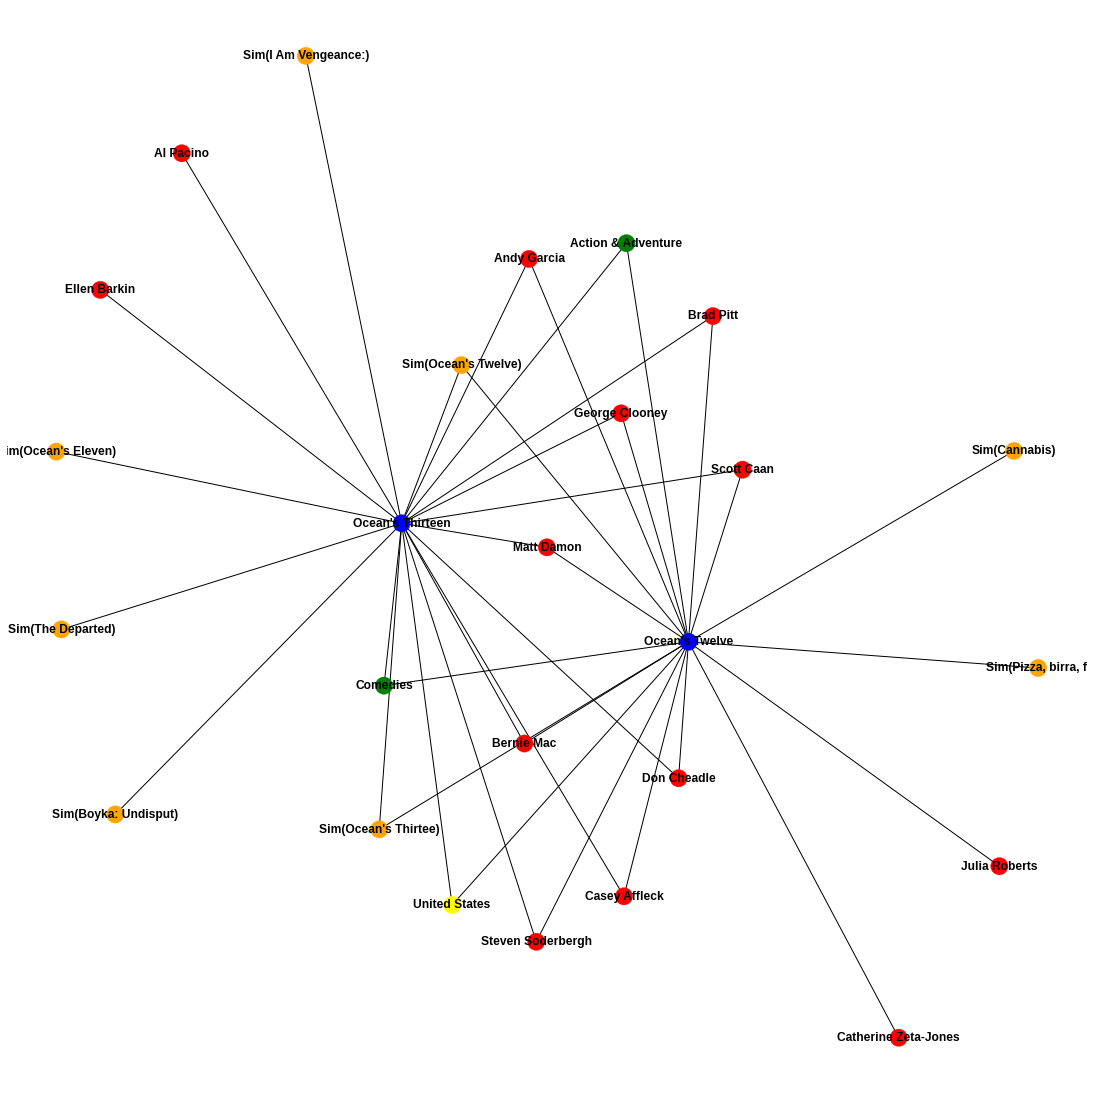

In [14]:
list_mo=["Ocean's Twelve", "Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_mo)
draw_sub_graph(sub_graph)